In 2020 the world was taken over by the global Covid 19 pandemic.<br>

<h1>Covid Dataset</h1>
This investigation made from datasets on: Cases, Patient Info, Time series on Age, Gender and Provinces for Covid spread. There's additional information on Weather trends, Region, Search Trends in Korea and Policy.

<h1>Objective</h1>

* Investigate data set.
* Perform Data cleaning and exploratory data analysis.
* Provide insights for future pandemics.

Prepare libraries, definitions. Data cliening was performed at data_clean.ipynb file

In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from urllib.request import urlopen
import json

In [2]:
geo_json = r"https://raw.githubusercontent.com/southkorea/southkorea-maps/master/gadm/json/skorea-provinces-geo.json"

with urlopen(geo_json) as response:
    counties = json.load(response)

for i in range(len(counties['features'])):
    if counties['features'][i]['properties']['NAME_1'] == 'Jeju':
        counties['features'][i]['properties']['NAME_1'] = 'Jeju-do'

In [3]:
def clean_date(df, feature):
    ### Cleaning Date columns ###
    df[feature] = pd.to_datetime(df[feature].replace(
        ['-', ' '], np.nan), format='%Y-%m-%d')

def map_province(df, feature, title):
    ### Plotly gragh for case distribustion in Korea ###
    province_dist = df[['Province', feature]].groupby(
        'Province').sum(feature).reset_index()

    fig = px.choropleth(province_dist, geojson=counties, locations='Province', color=feature,
                        color_continuous_scale="Reds",
                        featureidkey="properties.NAME_1",
                        title=title,
                        fitbounds="locations",
                        width=800
                        )

    fig.update_layout(margin={"r": 0, "l": 0, "b": 0})

    fig.show()

def column_name(df):
    ### Capitalize column names ###
    df.columns = df.columns.str.strip().str.capitalize()


age_order = ['0s', '10s', '20s', '30s', '40s',
             '50s', '60s', '70s',  '80s', '90s', '100s']

In [4]:
### case ###
case = pd.read_csv(r"..\code\data\Case.csv")
column_name(case)
case['Latitude'] = case['Latitude'].replace('-', np.nan).astype(float)
case['Longitude'] = case['Longitude'].replace('-', np.nan).astype(float)


### patient_info ###
patient_info = pd.read_csv(r"..\code\data\PatientInfo.csv")
column_name(patient_info)

clean_date(patient_info, 'Symptom_onset_date')
clean_date(patient_info, 'Confirmed_date')
clean_date(patient_info, 'Released_date')
clean_date(patient_info, 'Deceased_date')

patient_info['Contact_number'] = patient_info['Contact_number'].replace(
    ['-', ' '], np.nan).astype(float)

### time ###
time = pd.read_csv(r"..\code\data\Time.csv")
column_name(time)
time = time.drop(columns='Time')
clean_date(time, 'Date')

### time_age ###
time_age = pd.read_csv(r"..\code\data\TimeAge.csv")
column_name(time_age)

time_age = time_age.drop(columns='Time')
clean_date(time_age, 'Date')

### time_gender ###
time_gender = pd.read_csv(r"..\code\data\TimeGender.csv")
column_name(time_gender)

time_gender = time_gender.drop(columns='Time')
clean_date(time_gender, 'Date')

### time_province ###
time_province = pd.read_csv(r"..\code\data\TimeProvince.csv")
column_name(time_province)

time_province = time_province.drop(columns='Time')
clean_date(time_province, 'Date')

### region ###
region = pd.read_csv(r"..\code\data\Region.csv")
column_name(region)

### weather ###
weather = pd.read_csv(r"..\code\data\Weather.csv")
column_name(weather)
clean_date(weather, 'Date')
weather['Year'] = weather['Date'].dt.year
weather['Month'] = weather['Date'].dt.month

### search ###
search = pd.read_csv(r"..\code\data\SearchTrend.csv")
column_name(search)
clean_date(search, 'Date')
search['Year'] = search['Date'].dt.year
search['Month'] = search['Date'].dt.month

### policy ###
policy = pd.read_csv(r"..\code\data\Policy.csv")
column_name(policy)

policy = policy.rename(columns={'Gov_policy': 'Government_Policy'}).drop(
    columns=['Policy_id', 'Country'])
clean_date(policy, 'Start_date')
clean_date(policy, 'End_date')

policy.loc[policy['Government_Policy'] == 'School Closure',
           'Government_Policy'] = 'Daycare Closure, School Opening Delay'

policy = policy.drop(policy[policy['Government_Policy'].isin(
    ['Close karaoke', 'School Opening Delay', 'Emergency Use Authorization of Diagnostic Kit']
    )].index)

for i, type in enumerate(policy['Type'].unique()):
    # Colour is based on Type and will come in handy for time series ###
    policy.loc[policy['Type'] == type, 'Color'] = f'C{i}'

In [5]:
sns.set_palette("twilight")

<h1>Overall Impact</h1>
2.07% of confirmed cases have deceased. 72.2% of hospitalized cases have recovered from being hospitalized. The peak of the pandemic came at March of 2020.

In [6]:
time_province['Deceased'].sum()/time_province['Confirmed'].sum() * 100

2.079634301457628

In [7]:
time_province['Released'].sum()/time_province['Confirmed'].sum() * 100

72.18558161370655

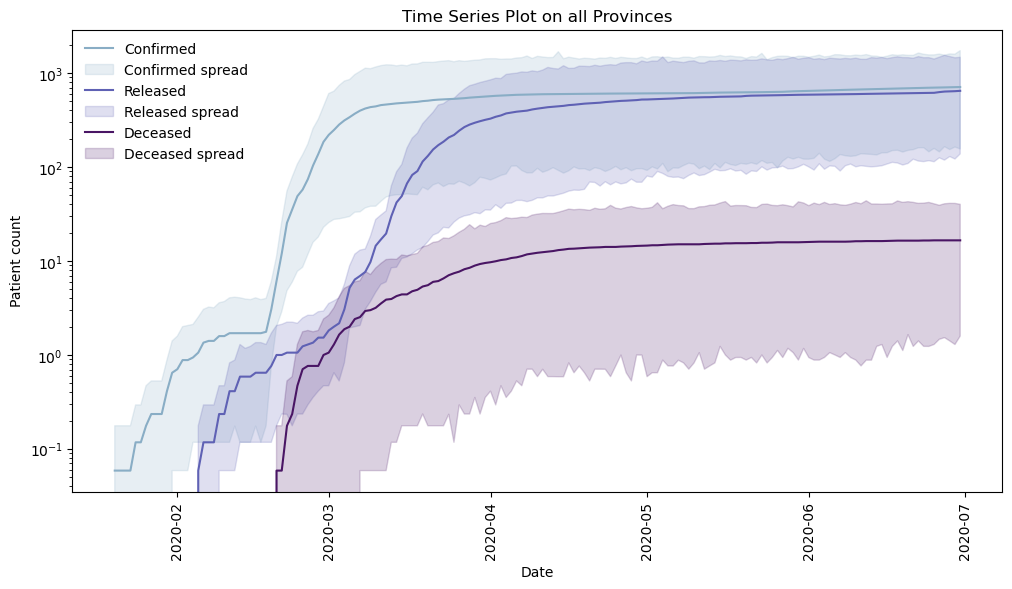

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Confirmed', data=time_province).set(
    title='Time Series Plot on all Provinces')
sns.lineplot(x='Date', y='Released', data=time_province)
sns.lineplot(x='Date', y='Deceased', data=time_province)

plt.legend(labels=['Confirmed', 'Confirmed spread', 'Released', 'Released spread',
           'Deceased', 'Deceased spread'], frameon=False, loc='upper left')
plt.ylabel('Patient count')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.yscale('log')

<h1>Why did some cities got hit harder by Covid?</h1>
Korean cities usually scale up similarly for kindergartens, elementary schools, Universities and Nursing homes. Most Korean elderly people live alone (seen from positive correlation > 0.9).

In [9]:
region[['Kindergarten_count', 'Elementary_school_count', 'University_count', 'Nursing_home_count', 'Academy_ratio',
        'Elderly_population_ratio', 'Elderly_alone_ratio']].corr().style.background_gradient(cmap='coolwarm')

,Kindergarten_count,Elementary_school_count,University_count,Nursing_home_count,Academy_ratio,Elderly_population_ratio,Elderly_alone_ratio
Kindergarten_count,1.000000,0.998604,0.993414,0.986783,0.080832,-0.105287,-0.096907
Elementary_school_count,0.998604,1.000000,0.995520,0.987042,0.074542,-0.093582,-0.086028
University_count,0.993414,0.995520,1.000000,0.989203,0.081918,-0.105257,-0.100359
Nursing_home_count,0.986783,0.987042,0.989203,1.000000,0.089914,-0.114462,-0.111793
Academy_ratio,0.080832,0.074542,0.081918,0.089914,1.000000,-0.627524,-0.578918
Elderly_population_ratio,-0.105287,-0.093582,-0.105257,-0.114462,-0.627524,1.000000,0.975789
Elderly_alone_ratio,-0.096907,-0.086028,-0.100359,-0.111793,-0.578918,0.975789,1.000000


Shincheonji Church is an outlier, inspecting with outliers.

In [10]:
city = case.groupby(['Province', 'City', 'Infection_case'])[
    'Confirmed'].sum().reset_index()

region_case = pd.merge(left=city, right=region,
                       how='left', on=['Province', 'City'])
region_case[region_case['Confirmed'] == region_case['Confirmed'].max()]

,Province,City,Infection_case,Confirmed,Code,Latitude,Longitude,Elementary_school_count,Kindergarten_count,University_count,Academy_ratio,Elderly_population_ratio,Elderly_alone_ratio,Nursing_home_count
31,Daegu,Nam-gu,Shincheonji Church,4511,12010.0,35.8463,128.597723,11.0,15.0,2.0,0.85,22.49,10.4,345.0


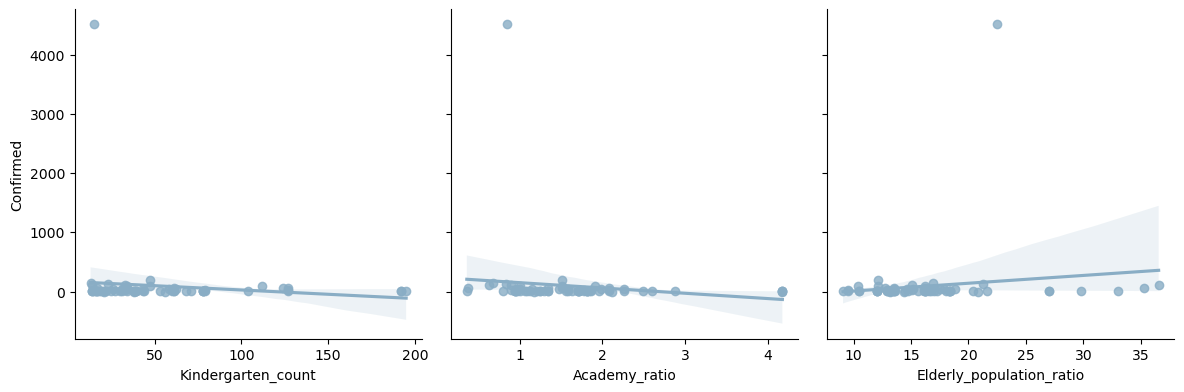

In [11]:
g = sns.PairGrid(region_case, y_vars=["Confirmed"], x_vars=['Kindergarten_count', 'Academy_ratio', 'Elderly_population_ratio'],
                 height=4, aspect=1, palette="GnBu_d"
                 )
g.map(sns.regplot);

Facility and Covid cases dependency without outlier Shincheonji Church shows that there's no correlation between facility count and Covid cases

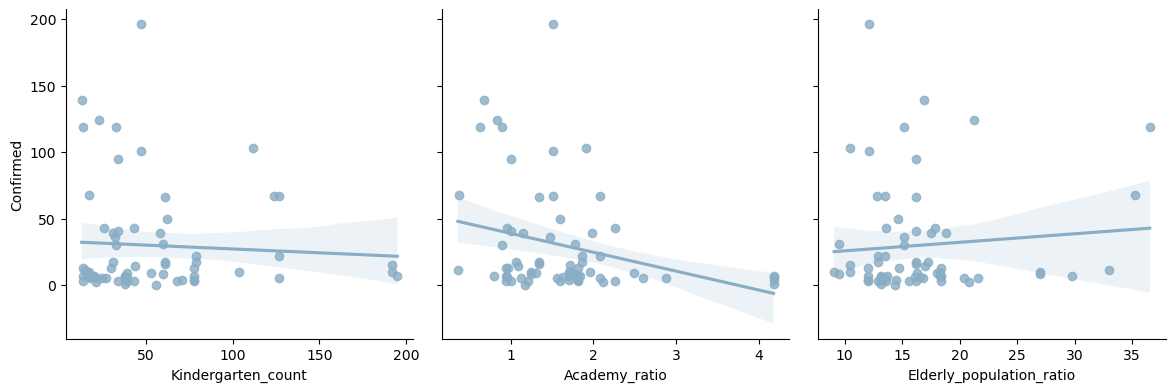

In [12]:
g = sns.PairGrid(region_case[region_case['Infection_case'] != 'Shincheonji Church'], y_vars=["Confirmed"], x_vars=['Kindergarten_count', 'Academy_ratio', 'Elderly_population_ratio'],
                 height=4, aspect=1, palette="GnBu_d"
                 )
g.map(sns.regplot);

Conclusion: 
* Most elderly people live alone.
* More facilities doen't mean more spreading events. 

<h1>Weather anomalies for 2016-2020</h1>
2020 data is available until June, this only first half of year is taken into account.<br>

In [13]:
weather[weather['Year'] == 2020]['Month'].max()

6

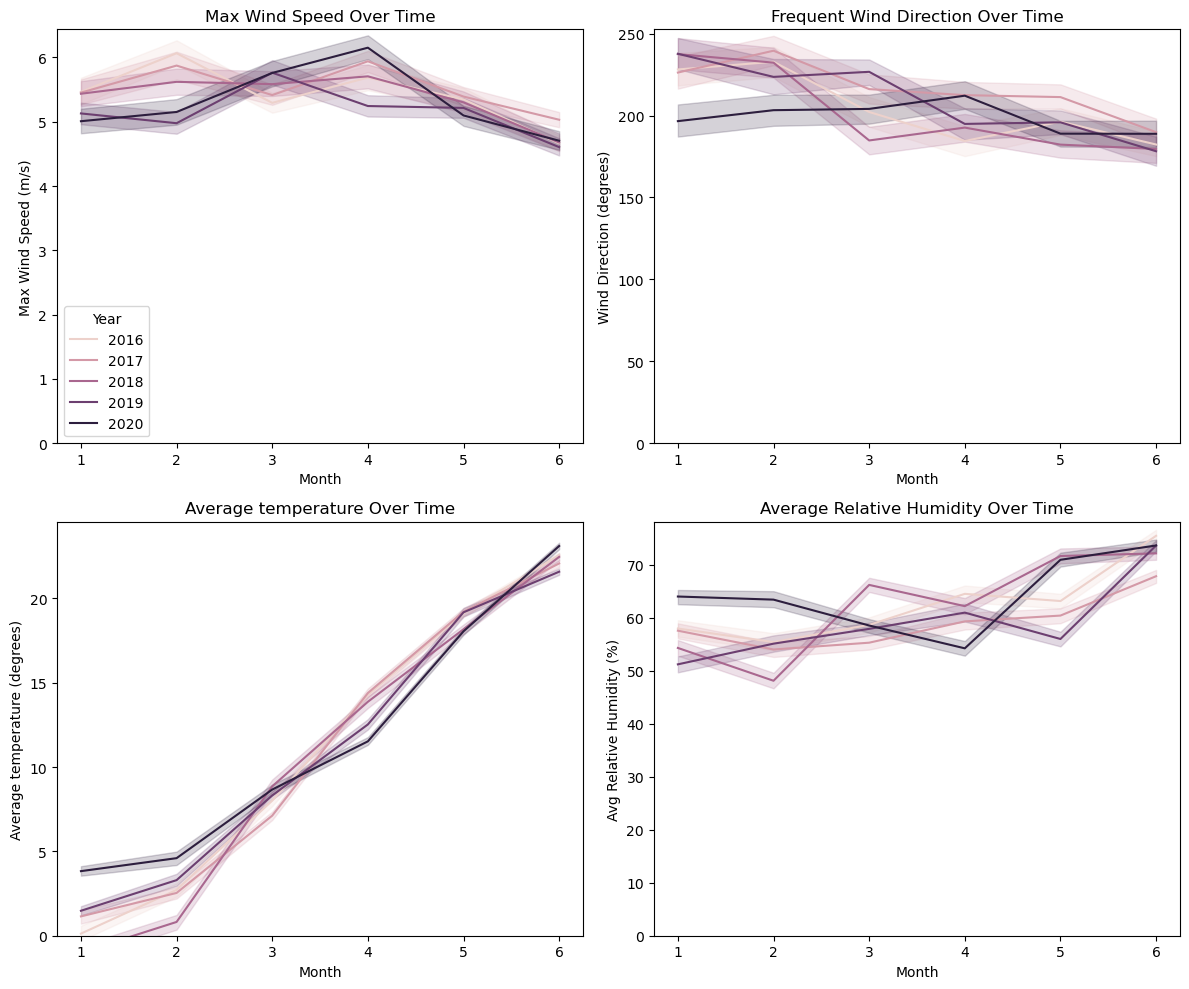

In [14]:
weather = weather[weather['Month'] < 7]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, title in enumerate(['Max_wind_speed', 'Most_wind_direction', 'Avg_temp', 'Avg_relative_humidity']):

    sns.lineplot(x='Month', y=title, data=weather, hue='Year', ax=axes[i])

    axes[i].set_ylim(0, None)
    if i > 0:
        axes[i].legend().set_visible(False)

axes[0].set_ylabel('Max Wind Speed (m/s)')
axes[0].set_title('Max Wind Speed Over Time')

axes[1].set_ylabel('Wind Direction (degrees)')
axes[1].set_title('Frequent Wind Direction Over Time')

axes[2].set_ylabel('Average temperature (degrees)')
axes[2].set_title('Average temperature Over Time')

axes[3].set_ylabel('Avg Relative Humidity (%)')
axes[3].set_title('Average Relative Humidity Over Time')

plt.tight_layout();

Conclusion:
* Winter of 2020 is slightly less windy, a bit warmer and more humid. 
* Overall, weather of 2020 doesn't look non-ordinary.

<h1>Infection case Investigation</h1>
<h2>Most afftected provinces</h2>
Daegu was the most affected province with over 807,5k Confirmed cases and 17,6k Deceased cases. Second biggest number of cases are in Gyeongsangbuk-do, which is next to Daegu. Daegu is not the capital (capital Seoul has 48,7k Confirmed cases) and this finding is not expected.
Daegu has much higher levels of Confirmed and Deceased patients than the capital Seoul. Surprisingly, these provinces are not near each other.

In [15]:
time_province.groupby('Province').sum('Deceased').sort_values('Deceased', ascending=False).head(5)

,Confirmed,Released,Deceased
Province,,,
Daegu,807506,600431,17624
Gyeongsangbuk-do,161079,117042,5393
Gyeonggi-do,81059,52096,1600
Busan,16341,12678,299
Seoul,81923,48687,298


<h2>Daegu - cross province spreader event</h2>
Daegu was hit with a church super spreader event in Shincheonji Church, a lot of people had contacts with patients or couldn't recall the moment of disease contracting.

In [16]:
case[['Infection_case', 'Province', 'Confirmed']].groupby(['Province', 'Infection_case']).sum(
    'Confirmed').sort_values(by='Confirmed', ascending=False).head(10)

Confirmed
Province         Infection_case                  
Daegu            Shincheonji Church          4511
                 contact with patient         917
                 etc                          747
Gyeongsangbuk-do Shincheonji Church           566
Gyeonggi-do      overseas inflow              305
Seoul            overseas inflow              298
Daegu            Second Mi-Ju Hospital        196
Gyeongsangbuk-do contact with patient         190
Seoul            contact with patient         162
                 Itaewon Clubs                139

Shincheonji Church attendees went to other provinces, note that Jeju-do island province was not visited by Shincheonji Church attendees.

This line is outcommented for data storage purposes

In [19]:
# map_province(case[case['Infection_case'] == 'Shincheonji Church'], 'Confirmed','Confirmed Cases  from Shincheonji Church')

Shincheonji Church case was like adding fuel to fire as other cases were making stark incline. Province boarders and large church gatherings have allowed the situation to become worse.

<h3>What were the patiens in Chuch super spreader event?</h3>
2 females (50 Years and 60 Years) were the biggest spreaders in Shincheonji Church

In [20]:
patient_info[(patient_info['Infection_case'] == 'Shincheonji Church')][['Sex', 'Age', 'Country',
                                                                        'Province', 'Contact_number']].sort_values(by='Contact_number', ascending=False).head()

,Sex,Age,Country,Province,Contact_number
1463,female,60s,Korea,Daegu,1160.0
1318,male,20s,China,Busan,485.0
1323,female,50s,Korea,Busan,296.0
2368,female,30s,Korea,Gyeonggi-do,53.0
3435,male,50s,Korea,Gangwon-do,45.0


Conclusion: 
* Daegu had a superspreader event and it acted a fuel to fire.
* Patients from Shincheonji Church went arround the country and spread Covid to other provinces.

<h1>Foreign / Internal Covid Spread</h1>
Covid starts with the expected overseas inflow, then numbers on internal cases explode. Unexpectedly, overseas inflow takes off at 2020-04. Most overseas inflow come to Seoul and Gyeonggi-do (which is arround Seoul)

In [21]:
case[case['Infection_case'] == 'overseas inflow'][['Province', 'Confirmed']].groupby(
    'Province').sum('Confirmed').sort_values(by='Confirmed', ascending=False).head()

,Confirmed
Province,
Gyeonggi-do,305
Seoul,298
Incheon,68
Daegu,41
Busan,36


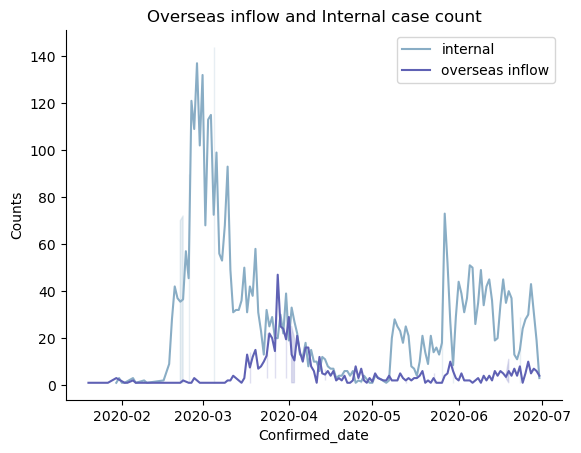

In [22]:
foreign_internal = patient_info[[
    'Infection_case', 'Confirmed_date', 'Country']]

foreign_internal.loc[foreign_internal['Country']
                     != 'Korea', 'Country'] = 'Foreign'
foreign_internal.loc[foreign_internal['Infection_case']
                     != 'overseas inflow', 'Infection_case'] = 'internal'

foreign_internal = foreign_internal.groupby(['Infection_case', 'Country', 'Confirmed_date'])[
    'Infection_case'].count().to_frame().rename(columns={"Infection_case": "Counts"}).reset_index()

sns.lineplot(x='Confirmed_date', y='Counts',
             data=foreign_internal, hue='Infection_case')
plt.title('Overseas inflow and Internal case count')
plt.legend(loc='upper right')
sns.despine();

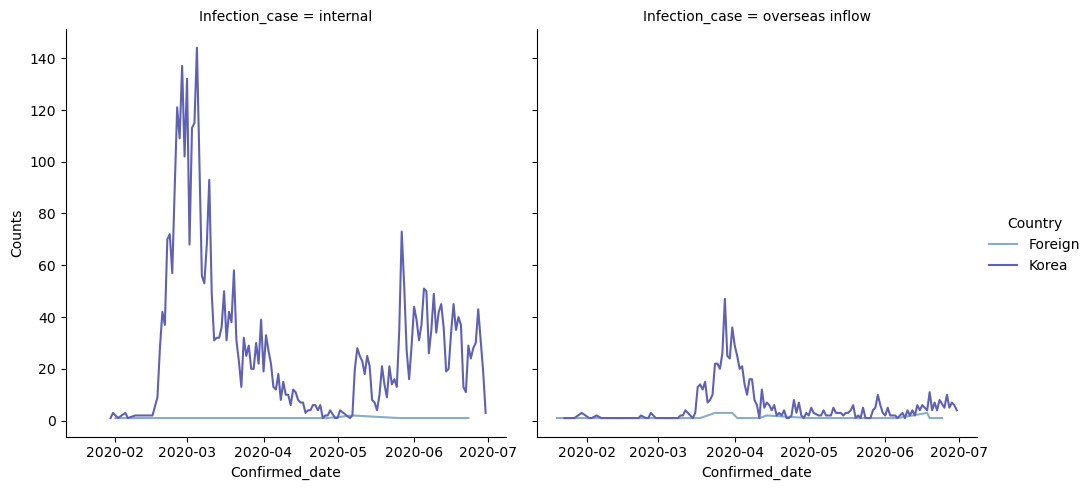

In [23]:
sns.relplot(data=foreign_internal, x="Confirmed_date", y="Counts",
            hue="Country", col="Infection_case", kind="line");

<h2>Overseas Inflow</h2>
Korean citizens are coming home. A turning point was the Mandatory 14-day Self Quarantine for people crossing the border.

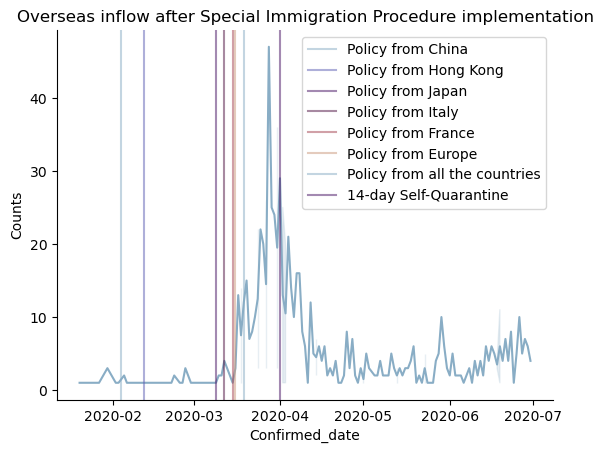

In [24]:
imigration = policy[(policy['Government_Policy'] ==
                     'Special Immigration Procedure')]

sns.lineplot(x='Confirmed_date', y='Counts', data=foreign_internal[(
    foreign_internal['Infection_case'] == 'overseas inflow')])

for i, date in enumerate(imigration['Start_date'].unique()):
    plt.axvline(x=date, color=f'C{i}', alpha=0.5,
                label=f"Policy {imigration[imigration['Start_date'] == date]['Detail'].values[0]}")

plt.axvline(x=policy[(policy['Government_Policy'] == 'Mandatory 14-day Self-Quarantine')]
            ['Start_date'].values[0], color=f'C{i+2}', alpha=0.5, label=f"14-day Self-Quarantine")

plt.legend()
plt.title('Overseas inflow after Special Immigration Procedure implementation')
sns.despine();

Overseas inflow is impacted by imigration policies. During Covid period imigration policies have been started, but none has been revoked.

In [25]:
policy[(policy['Type'] == 'Immigration') & ~policy['End_date'].isna()].shape[0]

0

<h3>Overseas inflow resolution</h3>
Most overseas patiens were hospitalised, as people were not yet familiar with Covid treating methods. In later analysis it will be showed that internal cases had 2 peaks, but due to migration policies, this was avoided for overseas inflow.

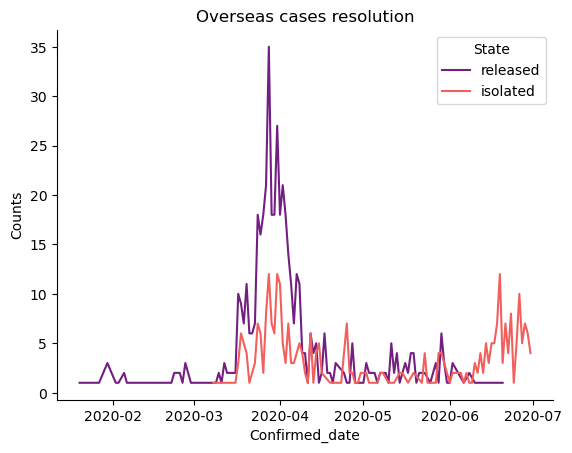

In [26]:
overseas_patients = patient_info[patient_info['Infection_case'] == 'overseas inflow'].groupby(
    ['Confirmed_date', 'State'])['State'].count().to_frame().rename(columns={"State": "Counts"}).reset_index()

sns.lineplot(x='Confirmed_date', y='Counts',
             data=overseas_patients, hue='State', palette='magma')
plt.title('Overseas cases resolution')
sns.despine();

<h2>Internal cases</h2>

There's 2 peaks for internal cases, with a dip arround 2020-05. First peak has up to 140 new confirmed cases/day, while Second peak has twice as less - up to 70 new cases/day. Korean government had reacted quickly with sanctions. First peak aligns with super-spreader event.

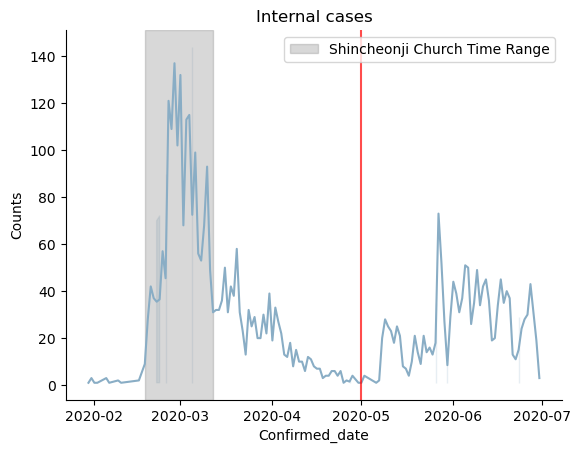

In [27]:
peak_sep = '2020-05-01'
shincheonji_church = patient_info[patient_info['Infection_case']
                                  == 'Shincheonji Church']['Confirmed_date'].unique()

sns.lineplot(x='Confirmed_date', y='Counts', data=foreign_internal[(
    foreign_internal['Infection_case'] != 'overseas inflow')])
plt.axvline(x=peak_sep, color='red', alpha=0.7)

# Shincheonji Church Case Grey band
plt.axvspan(shincheonji_church.min(), shincheonji_church.max(),
            alpha=0.3, color='gray', label='Shincheonji Church Time Range')


plt.legend(loc='upper right')

plt.title('Internal cases')
sns.despine()

<h3> First Peak</h3>
First peak happened arroud early Spring, which is also the flue season. Measures like social distancing and School closure helped reduce number of patients.

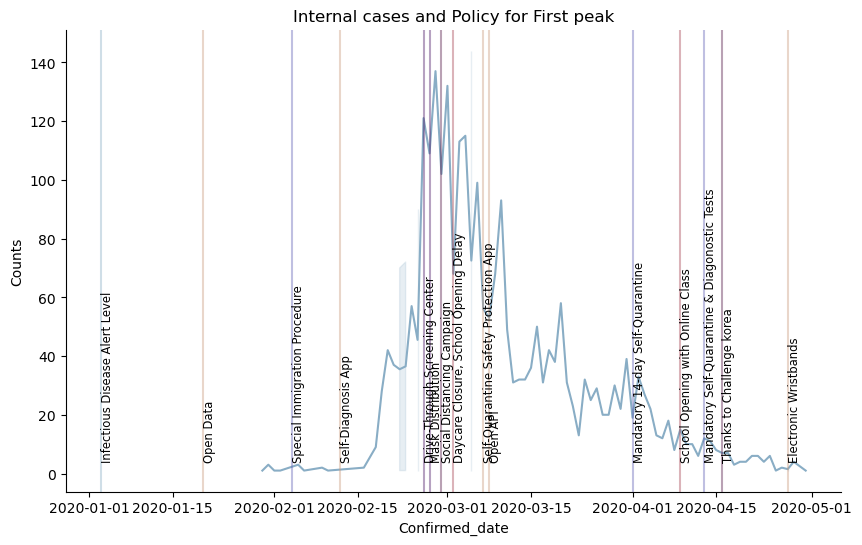

In [28]:
first_peak = policy[(policy['Start_date'] < peak_sep)][['Government_Policy',
                                                        'Start_date', 'Color']].drop_duplicates(['Government_Policy'], keep='first')


plt.figure(figsize=(10, 6))

sns.lineplot(x='Confirmed_date', y='Counts', data=foreign_internal[(foreign_internal['Infection_case'] != 'overseas inflow')
                                                                   & (foreign_internal['Confirmed_date'] < peak_sep)
                                                                   ])

for i, date in enumerate(first_peak['Start_date']):

    plt.axvline(
        x=date, color=first_peak[first_peak['Start_date'] == date]['Color'].values[0], alpha=0.4)
    plt.text(
        date, 5, first_peak['Government_Policy'].values[i], rotation=90, fontsize='small')

plt.title('Internal cases and Policy for First peak')
sns.despine();

<h3> Second Peak </H3>
Social gatherig places, like bars and clubs were closed down and extended tightened quarantine measures were implemented before Second peak could reach the First peak levels.

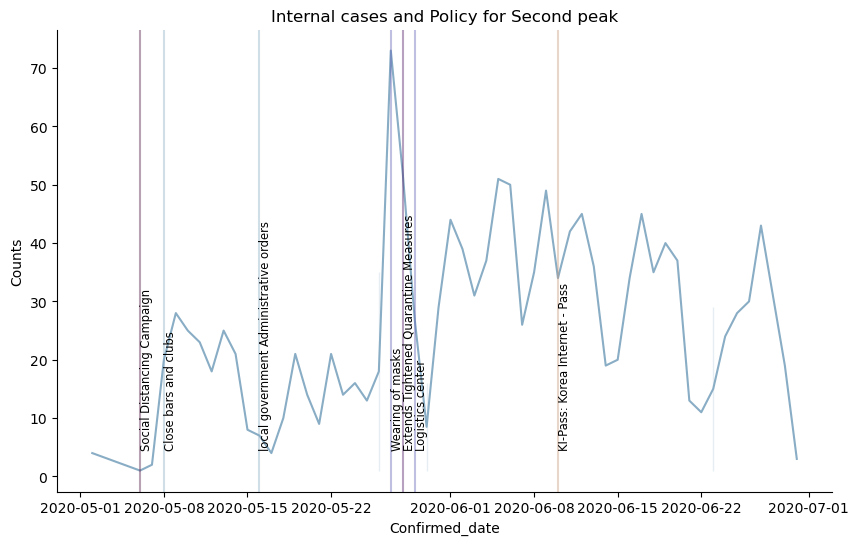

In [29]:
second_peak = policy[(policy['Start_date'] > peak_sep)][['Government_Policy',
                                                         'Start_date', 'Color']].drop_duplicates(['Government_Policy'], keep='first')

plt.figure(figsize=(10, 6))

sns.lineplot(x='Confirmed_date', y='Counts', data=foreign_internal[(foreign_internal['Infection_case'] != 'overseas inflow')
                                                                   & (foreign_internal['Confirmed_date'] > peak_sep)
                                                                   ])

for i, date in enumerate(second_peak['Start_date']):

    plt.axvline(
        x=date, color=second_peak[second_peak['Start_date'] == date]['Color'].values[0], alpha=0.4)
    plt.text(
        date, 5, second_peak['Government_Policy'].values[i], rotation=90, fontsize='small')

plt.title('Internal cases and Policy for Second peak')
sns.despine();

<h3>Internal cases resolution</h3>
First peak patients mostly went to the hospital, but Second peak patients were already anticipating the desease and were mostly isolated

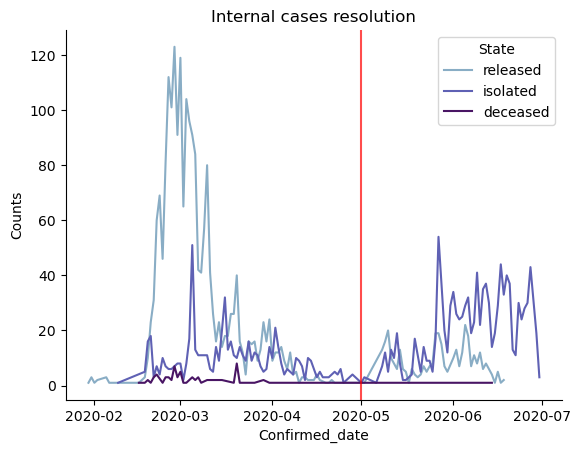

In [30]:
peak_patients = patient_info[patient_info['Infection_case'] != 'overseas inflow'].groupby(
    ['Confirmed_date', 'State'])['State'].count().to_frame().rename(columns={"State": "Counts"}).reset_index()

sns.lineplot(x='Confirmed_date', y='Counts', data=peak_patients, hue='State')
plt.axvline(x=peak_sep, color='red', alpha=0.7)
plt.title('Internal cases resolution')
sns.despine();

Conclusion: 
* Majority of overseas inflow made Korean sitizens coming home and bringing Covid along with them. Overseas case inflow stopped after 14 day mandatory Quarantine.
* Internal spread had 2 peaks - during March and beginning of Summer.
* Government acted quick with policies and measures.
* Second peak patients were not hospitalised like the First peak.

<h1>Covid deadliness and most venerable patients</h1>
Symptoms are showing after 14 days. The desease usually takes 20.5 days to take the life of the patiens. Patients are reliesed after 1 month.

In [31]:
((patient_info['Released_date'] - patient_info['Symptom_onset_date']
  ) / np.timedelta64(1, 'D')).mean()

31.595238095238095

In [32]:
((patient_info['Deceased_date'] - patient_info['Symptom_onset_date']
  ) / np.timedelta64(1, 'D')).mean()

20.5

Young children experience symptoms within a few days, but usully symptoms start after 1 week. This dataset is too small for Sex comparition.

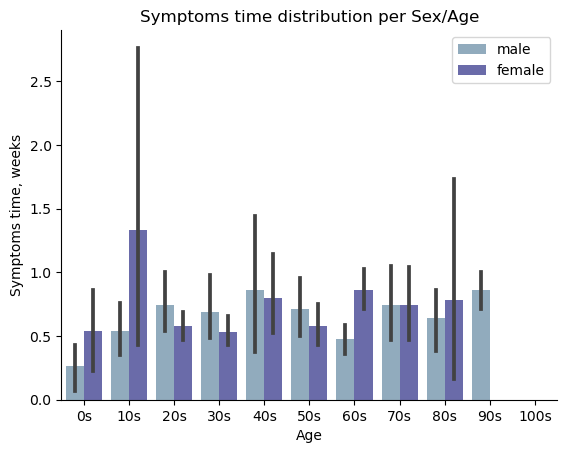

In [33]:
patient_info['symptoms_time'] = (
    patient_info['Confirmed_date'] - patient_info['Symptom_onset_date']) / np.timedelta64(1, 'W')

ax = sns.barplot(data=patient_info[~patient_info['symptoms_time'].isna(
)], x="Age", y='symptoms_time', hue="Sex", order=age_order)
ax.set(ylabel='Symptoms time, weeks',
       title='Symptoms time distribution per Sex/Age')
plt.legend(loc='upper right')
sns.despine();

No Deceased until 30s

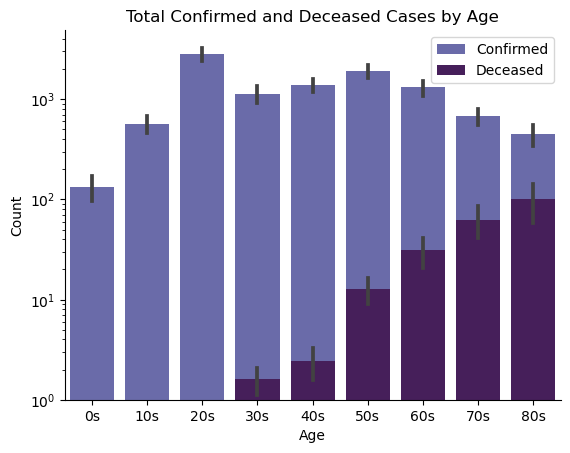

In [34]:
sns.barplot(data=time_age, x='Age', y='Confirmed',
            color='C1', label='Confirmed', errorbar="sd")
sns.barplot(data=time_age, x='Age', y='Deceased',
            color='C2', label='Deceased', errorbar="sd")

plt.title('Total Confirmed and Deceased Cases by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylim(0.999, None)
sns.despine();

* Mortality of Males looks greater than Females at firt sight, but using the Standart deviation on either category shows that there's no destinction between Male and Female mortality.
* Modernworld populations generaly have more females than males, this could hint on higher Female Confirmed cases.

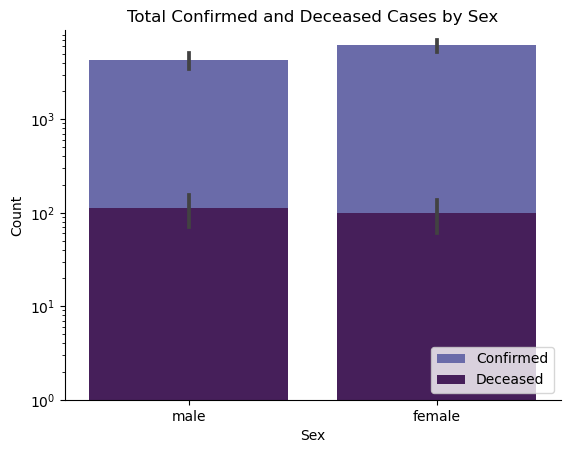

In [35]:
sns.barplot(data=time_gender, x='Sex', y='Confirmed',
            color='C1', label='Confirmed', errorbar="sd")
sns.barplot(data=time_gender, x='Sex', y='Deceased',
            color='C2', label='Deceased', errorbar="sd")

plt.title('Total Confirmed and Deceased Cases by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(loc='lower right')
plt.yscale('log')
plt.ylim(0.999, None)
sns.despine();

Conclusion: Older patienss are more likely to die from Covid.

<h1>Search Trends</h1>
Search trend data is available only until June. New illness - Covid was signaled by 'Pneumonia' and 'Coronavirus' searches. Seasonal levels of 'Cold', 'Flu' were not uncommon, especialy in beggining of 2019.

In [36]:
search[search['Year'] == 2020]['Month'].max()

6

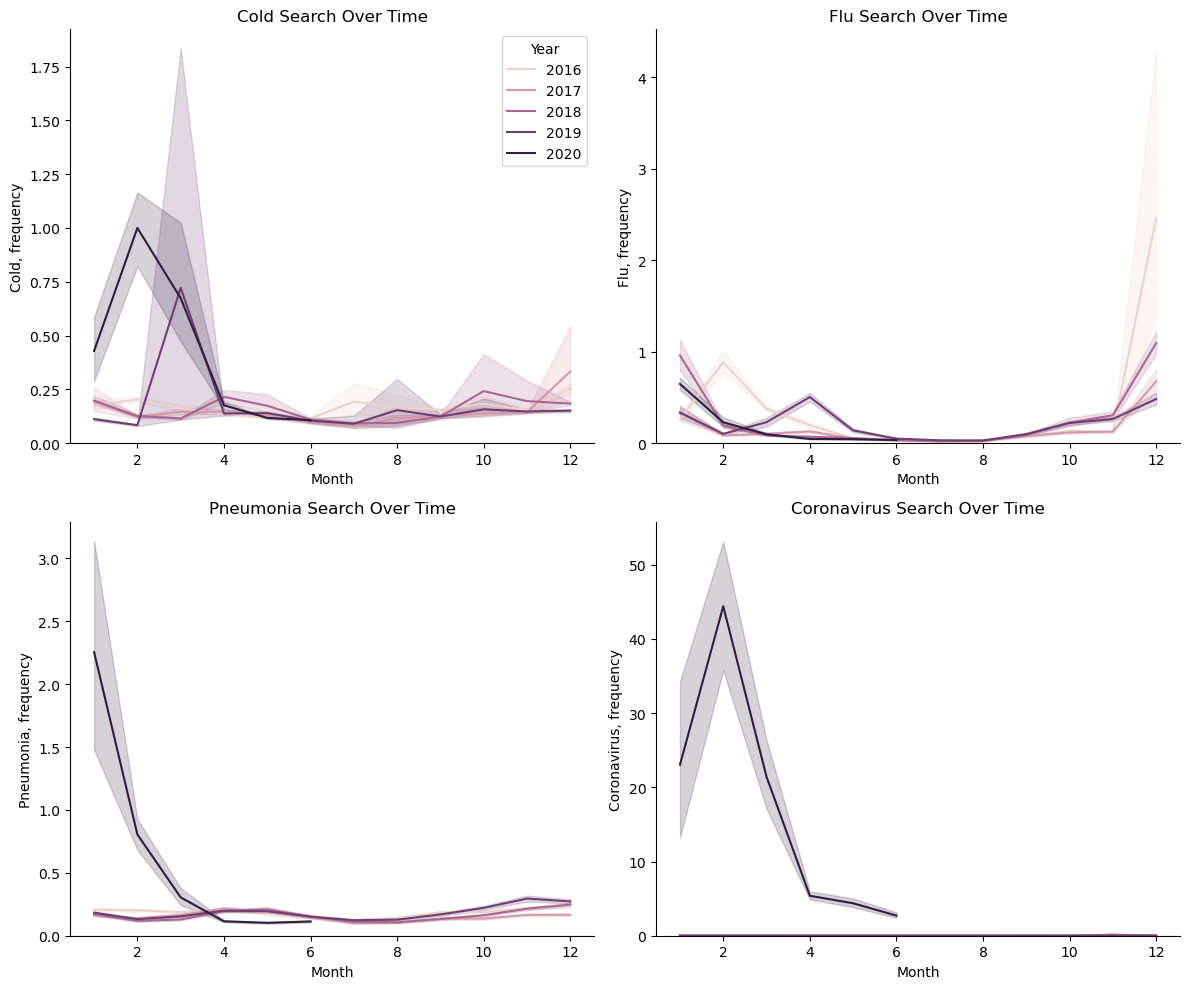

In [37]:
column_lst = ['Cold', 'Flu', 'Pneumonia', 'Coronavirus']


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, title in enumerate(column_lst):

    sns.lineplot(x='Month', y=title, data=search, hue='Year', ax=axes[i])

    axes[i].set_ylim(0, None)
    axes[i].set_ylabel(f'{title}, frequency')
    axes[i].set_title(f'{title} Search Over Time')
    if i > 0:
        axes[i].legend().set_visible(False)


plt.tight_layout()
sns.despine()

Looking closer to 2020: 'Pneumonia' and 'Coronavirus' show similar trends, Civid period most reached term was 'Coronavirus'

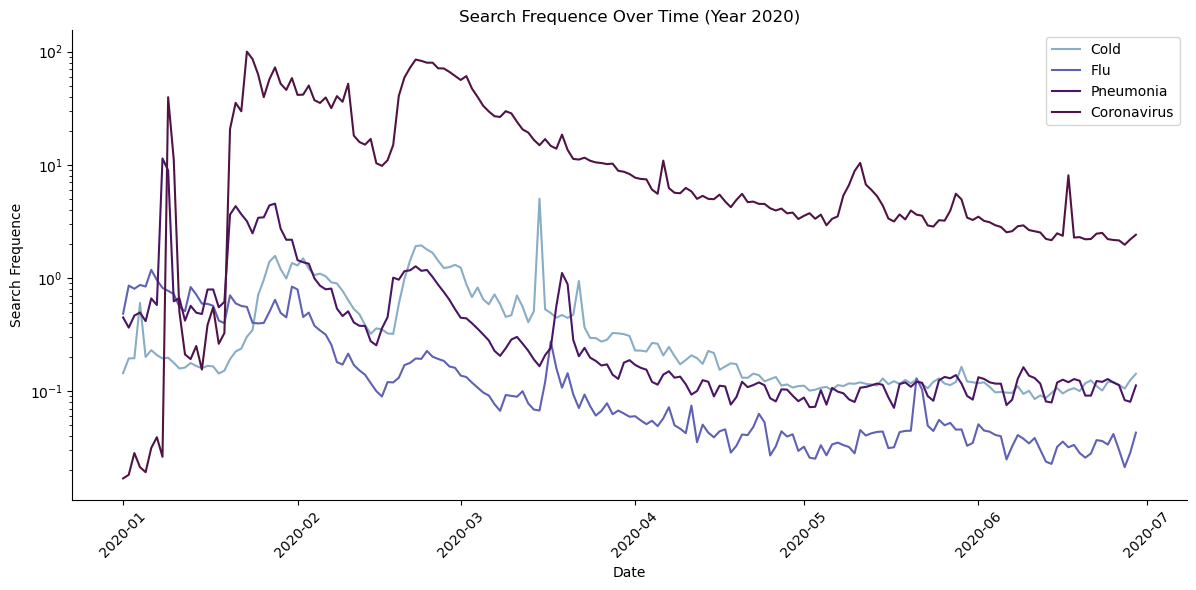

In [38]:
search_2020 = search[search['Year'] == 2020]

plt.figure(figsize=(12, 6))

sns.lineplot(data=search_2020, x='Date', y='Cold', label='Cold')
sns.lineplot(data=search_2020, x='Date', y='Flu', label='Flu')
sns.lineplot(data=search_2020, x='Date', y='Pneumonia', label='Pneumonia')
sns.lineplot(data=search_2020, x='Date', y='Coronavirus', label='Coronavirus')

plt.xlabel('Date')
plt.ylabel('Search Frequence')
plt.title('Search Frequence Over Time (Year 2020)')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.yscale('log')
sns.despine()

Search trends and Confirmed cases follow similar curve saturation rules:
* Chincheonji Church event was a turning point for Korea. Just before the event, Confirmed cases looked saturated, but the super-spreader event took maters to worse. 
* Similarly, Search Frequency looked saturated and got a new peak after super-spreader event.

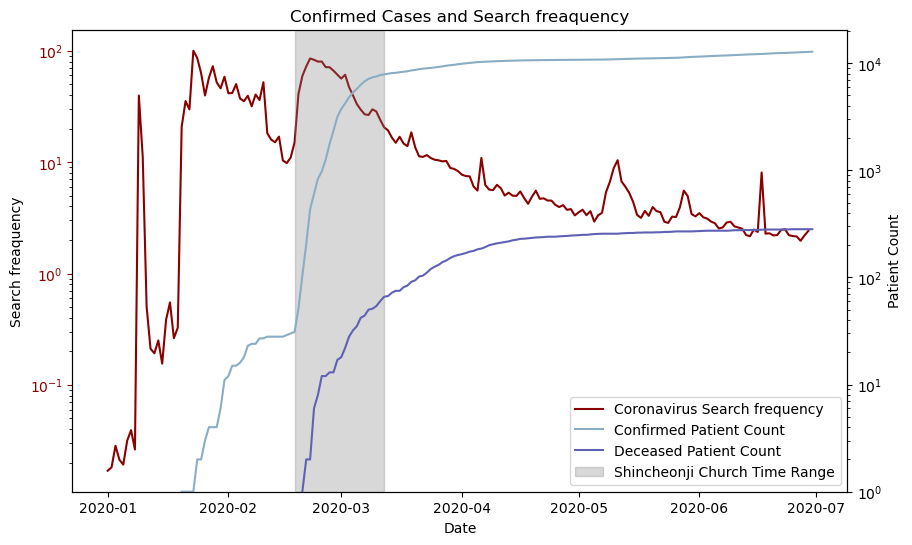

In [39]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis on the right for 'Coronavirus freaquency'
sns.lineplot(data=search_2020, x='Date', y='Coronavirus',
             label='Coronavirus Search frequency', color='DarkRed', ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Search freaquency')
ax1.legend().set_visible(False)
plt.yscale('log')
plt.gca().spines['left'].set_color('DarkRed')
plt.tick_params(axis='y', colors='DarkRed')

# Second y-axis on the right for 'Patient Count'
ax2 = ax1.twinx()


sns.lineplot(data=time, x='Date', y='Confirmed',
             label='Confirmed Patient Count', ax=ax2)
sns.lineplot(data=time, x='Date', y='Deceased',
             label='Deceased Patient Count', ax=ax2)
ax2.legend().set_visible(False)
ax2.set_ylabel('Patient Count')
plt.yscale('log')
plt.ylim(0.999, None)

# Add a legend that combines both lines from the two axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()


# Shincheonji Church Case Grey band
plt.axvspan(shincheonji_church.min(), shincheonji_church.max(),
            alpha=0.3, color='gray', label='Shincheonji Church Time Range')

# # Add the legend with the custom legend element
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')


plt.title('Confirmed Cases and Search freaquency');

Deceased and Confirmed cases had a first saturation period before and during Shincheonji Church superspreader event:
* Confirmed cases saturated stopped being saturated at the start of Shincheonji Church superspreader event
* Deceased cases first saturated at 13/day

In [40]:
shincheonji_church_min = shincheonji_church.min()
shincheonji_church_max = shincheonji_church.max()

time[(time['Date'] > shincheonji_church_min) & (
    time['Date'] < '2020-03-01')][['Date', 'Deceased']]

,Date,Deceased
30,2020-02-19,0
31,2020-02-20,1
32,2020-02-21,2
33,2020-02-22,2
34,2020-02-23,6
35,2020-02-24,8
36,2020-02-25,12
37,2020-02-26,12
38,2020-02-27,13
39,2020-02-28,13


High volumes of testing helped Korea get the full picture of covid severity.

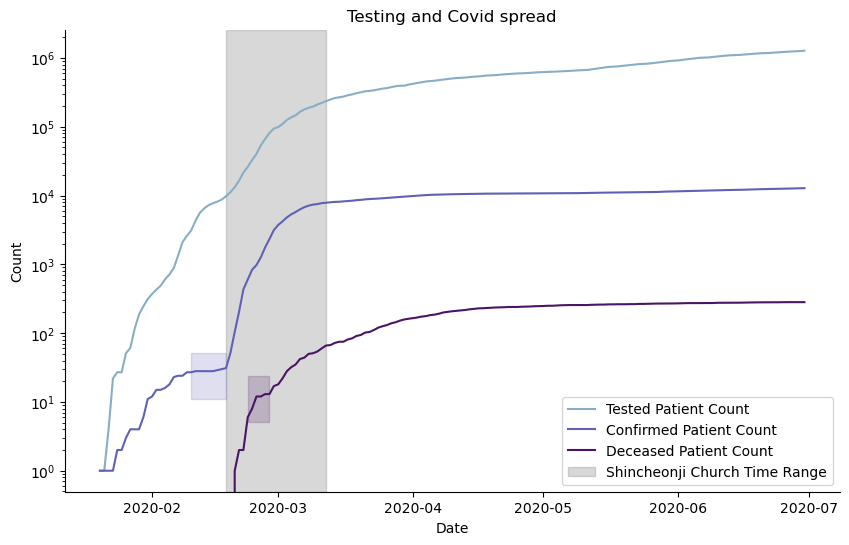

In [41]:
confirmed_saturation = time[time['Date'] < shincheonji_church_min][[
    'Confirmed']].describe(percentiles=[.90]).loc['90%'].values[0]
deceased_saturation = time[time['Date'] <
                           '2020-02-28']['Deceased'].describe(percentiles=[.90]).loc['90%']

confirmed_saturation_min = time[time['Confirmed']
                                < confirmed_saturation]['Date'].max()
deceased_saturation_min = time[time['Deceased']
                               < deceased_saturation]['Date'].max()


fig, ax1 = plt.subplots(figsize=(10, 6))


sns.lineplot(data=time, x='Date', y='Test', label='Tested Patient Count')
sns.lineplot(data=time, x='Date', y='Confirmed',
             label='Confirmed Patient Count')
sns.lineplot(data=time, x='Date', y='Deceased', label='Deceased Patient Count')

# Shincheonji Church Case Grey band
plt.axvspan(shincheonji_church_min, shincheonji_church_max,
            alpha=0.3, color='gray', label='Shincheonji Church Time Range')
plt.axvspan(confirmed_saturation_min, shincheonji_church_min,
            alpha=0.2, ymin=0.2, ymax=0.3, color='C1')
plt.axvspan('2020-02-28', deceased_saturation_min,
            alpha=0.2, ymin=0.15, ymax=0.25, color='C2')


plt.xlabel('Date')
plt.ylabel('Count')
plt.yscale('log')
plt.legend()

plt.title('Testing and Covid spread')
sns.despine();

Conclusion:
* Search treands on internet mimic the real life events of citisens. 
* Testing in high volumes helps understand the real severity of pandemic.

<h1>Overall Conclusion</h1>
No effect:

* From first look 2020 might have looked like a special year, but no weather anomalies were found. <br>

Bad example: <br>

* Covid was spread by human interactions - Super spreader event of Shincheonji Church made bad situation worse. Province border shut down would have prevented it.<br>


Good example: 

* Overseas inflow cases has been stopped after mandatory 14 day quarantine (Covid symptoms mostly show by 2 weeks).
* Most venerable patients are elderly, but high numbers of Korean elderly live alone and this came in favor when pandemic hit.
* Search trends gives a glimpse into real time event of population.
* Large amount of testing helps evaluate the severity of pandemic. 